In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: PeriodicKernel, SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature
using Roots, DomainSets


[ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
[ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]


## Prepare data 

In [3]:
function generate_data(n, f_gp, c_gp, σ_y)
    y=[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
        push!(obs, temp + σ_y*randn())
    end
    return y , obs
end

generate_data (generic function with 1 method)

## Specify model

In [4]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output

In [411]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    dist = LogNormal(m_gp[index],cov_gp[index,index]+1e-2)
    return dist
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    dist = LogNormal(mean(m_x), var(m_x))
    return dist
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    μ_y, var_y =  mean_var(m_y)
    log_pdf = (x) -> logpdf(NormalMeanVariance(μ_y, var_y),exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end

In [6]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,1000)
    weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    weight = weights / sum(weights)
    m = sum(weight .* log.(sample_left))
    v = sum(weight .* (log.(sample_left) .- m).^2)
    return LogNormal(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return @call_rule typeof(*)(:A, Marginalisation) (m_out=m_out,m_in=m_in,meta=TinyCorrection())
end




In [7]:
#Test with GP with fixed hyperparameters
@model function modulation(n, precision,amplitude_kernel,amplitude_mean, carrier_kernel, carrier_mean,train,test, gpstrategy1,gpstrategy2)
    amplitude   = randomprocess(test, train, gpstrategy1)
    carrier     = randomprocess(test, train, gpstrategy2)
    observation = datavar(Float64,n)
    g = randomvar(n)
    w = randomvar(n)

    amplitude ~ GaussianProcess(amplitude_mean, amplitude_kernel, log(θamplitude))
    carrier   ~ GaussianProcess(carrier_mean, carrier_kernel, log(θcarrier))
    for i=1:n 
        g[i] ~ MyExponential(amplitude) where {meta = ProcessMeta(i)}
        w[i] ~ *(carrier, g[i]) where {meta = ProcessMeta(i)}
        observation[i] ~ NormalMeanPrecision(w[i],precision)
    end
end

In [435]:
# Random.seed!(10295)
σ_y = 0.0001 ## we assume low noise for now

N = 400; #data length
n = 400; #lenght of the axis of gp 
θcarrier   = 0.05
θamplitude = 0.5
mean_amplitude = (x) -> 0.3*sin(2pi*x*4) + 0.3*exp(-x^2);
mean_carrier   = (x) -> cos(2pi*x*10)
kernel_carrier(θ)     =  with_lengthscale(SqExponentialKernel(),θ)
kernel_amplitude(θ)   =  0.1*with_lengthscale(SqExponentialKernel(),θ) + with_lengthscale(PeriodicKernel(),3.0)
tmin,tmax = 0., 3.0
time_range = collect(range(tmin, tmax; length=n));
Cov_amplitude = kernelmatrix(kernel_amplitude(θamplitude),time_range,time_range) + 1e-7*I;
Cov_carrier   = kernelmatrix(kernel_carrier(θcarrier),time_range,time_range) + 1e-7I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_gt = rand(gp_amplitude)
carrier_gt   = rand(gp_carrier)
#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]


#Generate data 
y_true_state,y_data = generate_data(n,amplitude_gt,carrier_gt,σ_y);

cov_strategy1 = CovarianceMatrixStrategy(FullCovarianceStrategy())
cov_strategy2 = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy = CovarianceMatrixStrategy(SoR(50))

iresult = inference(
    model = modulation(length(y_data),1/σ_y^2, kernel_amplitude,mean_amplitude, kernel_carrier,mean_carrier, time_train,time_range, cov_strategy1,cov_strategy2),
    initmessages = (
#                     amplitude  = GaussianProcess(mean_amplitude,kernel_amplitude(θamplitude),MvNormalMeanCovariance(mean_amplitude.(time_range),Cov_amplitude),time_range,time_train,Float64[], cov_strategy1),
                    carrier  = GaussianProcess(mean_carrier,kernel_carrier(0.1),MvNormalMeanCovariance(mean_carrier.(time_range),Cov_carrier),time_range,time_train,Float64[], cov_strategy2),
                    ),
    returnvars = (amplitude=KeepEach(),carrier=KeepEach()),
    data  = (observation = y_data,),
    showprogress = true,
    free_energy = false,
)

Inference results:
  Posteriors       | available for (amplitude, carrier)


In [436]:
mamplitude = mean(iresult.posteriors[:amplitude][end].data.finitemarginal)
vamplitude = var(iresult.posteriors[:amplitude][end].data.finitemarginal)
expvgp = exp.( mamplitude .+ vamplitude)
expmgp = exp.(mamplitude);

mcarriers = mean(iresult.posteriors[:carrier][end].data.finitemarginal)
vcarriers = var(iresult.posteriors[:carrier][end].data.finitemarginal);

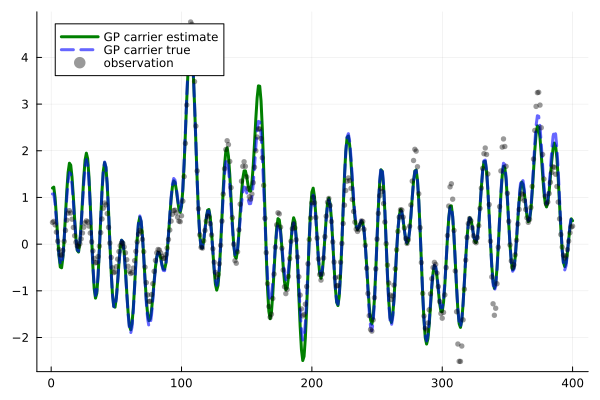

In [440]:
from = 1
to   = N
skip = 1

plot(mcarriers[from:skip:to],ribbon=sqrt.(abs.(vcarriers[from:skip:to])),label="GP carrier estimate",linewidth=3.0, fillalpha=0.2, color="green")
plot!(carrier_gt[from:skip:to],linewidth=3.0, color="blue", label="GP carrier true",alpha=0.6,ls=:dash)
scatter!(y_data[from:skip:to], label="observation",color=:black,alpha=0.4,ms=3)

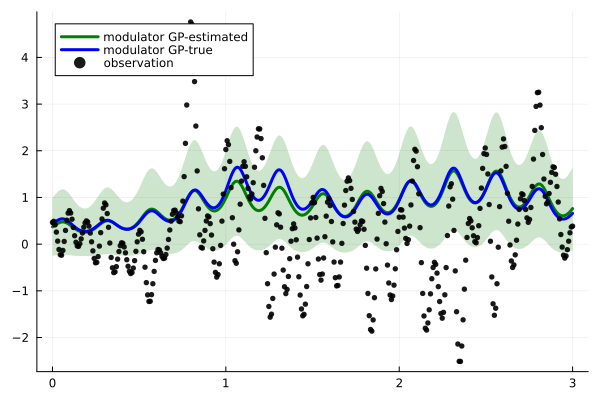

In [438]:

plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(amplitude_gt), label="modulator GP-true",linewidth=3.0,color=:blue)
scatter!(time_range,y_data, label="observation",color=:black,alpha=0.9,ms=3)
